**Group ID:** 9

**Kaggle Team Name:** Normal BGs

**Author 1 (sciper):** Sébastien Chaoud (316240)       
**Author 2 (sciper):** Marine Moutarlier (310703)       
**Author 3 (sciper):** Paul Boulenger (312041)


In [20]:
import pandas as pd
import numpy as np
from segmentation_utils import *
import json
import os
from bg_classification_utils import BackgroundClassifier
from coin_calssification_utils import get_test_data_loader, get_model
import joblib
import scipy

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Paths
test_image_dir = 'data/test/'
test_image_dir_triage = 'data/test_triage/'
test_image_paths = list(sorted(os.listdir(test_image_dir)))

In [11]:
# Load the data
test_images = [read_image(test_image_dir + image_path) for image_path in tqdm(test_image_paths, desc='Loading images')]

Loading images:   0%|          | 0/162 [00:00<?, ?it/s]

Loading images: 100%|██████████| 162/162 [01:22<00:00,  1.96it/s]


# Background Classification

To detect the coin on each image, we will apply a segmentation process. This segmentation process is distinct for each background type. Hence we first need to detect the background of each image. To do so, we trained an basic SVM classifer on image color moment features. For more details about this classification model and the training, please see `tuning_and_training.ipynb` notebook.

In [21]:
# Compite the image features
def color_moments(image: np.ndarray) -> list[float]:
    moments = []
    for i in range(3):  # Iterate over the color channels
        channel = image[:, :, i]
        moments.extend([np.mean(channel), np.std(channel), scipy.stats.skew(channel.flatten())])
    return moments

MODELS_DIR = 'models_weights'

# Create the background classifier for inference
class BackgroundClassifier:
    model_path = f'{MODELS_DIR}/bg_classifier_small.pkl'
    scaler_path = f'{MODELS_DIR}/bg_scaler_small.pkl'
    label_map = {0: 'neutral', 1: 'noisy', 2: 'hand'}
    labels = list(label_map.values())

    def __init__(self):
        # Load the trained model and the scaler used on the train set
        self.model = joblib.load(self.model_path) if os.path.exists(self.model_path) else None
        self.scaler = joblib.load(self.scaler_path) if os.path.exists(self.scaler_path) else None

    def predict(self, images: list[np.ndarray]) -> list[str]:
        if self.model is None or self.scaler is None:
            raise ValueError('Model not trained yet')

        small_images = [resize_image(im, (300, 200)) for im in images] # Resize the images
        features = np.array([color_moments(im) for im in tqdm(small_images, desc='Extracting features')])
        features = self.scaler.transform(features)
        pred = self.model.predict(features)
        return [self.label_map[p] for p in pred]

In [22]:
# Predict the background
bg_classifier = BackgroundClassifier()
bg_labels = bg_classifier.predict(test_images)

Extracting features: 100%|██████████| 162/162 [00:00<00:00, 244.16it/s]


In [5]:
# Save the images
for i  in tqdm(range(len(test_images)), total=len(test_images), desc='Saving images'):
    save_dir = test_image_dir_triage + bg_labels[i]
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    save_image(test_images[i], save_dir + '/' + test_image_paths[i])

Saving images: 100%|██████████| 162/162 [02:23<00:00,  1.13it/s]


In [6]:
#For memory issues
del test_images
del bg_classifier

# Coin Extraction

The next step is to perfrom a segmentation of the images to extract the coins, to so:
- We computed the median across all images of a given background, which should give use a backgournd image (i.e with no coins) 
- We substract (absolute image substraction) from each image its corresponding bakcground, hoping to get an image whoise high value pixels are the one belonging to a coin
- We observe different pixel channels (`RGB` or `LAB`) distribution (after resizing for computational efficiency) to determine a thresholding method to extract the coins
- We use this threshold to 0-out more pixels
- We apply binary tranforms such as `closing`...
- We are now ready to extract the coins using `cv2.HoughTransform`
- We create bounding squares around these and extract theze from the orginal size images. We still wanted to be able to keep all resolution from here. We thought we may need it later in the process
- To make the images unifrom, we use 1000x1000 pad fro their background.


Note: the details of the hyperparameters choice, the computation of the backgrounds etc. can be found in `tuning_and_training.ipynb` and `segementation_utils`

In [7]:
# Paths
image_dir_triage = 'data/test_triage/'
image_path_hand = 'data/test_triage/hand/'
average_bg_path = "data/average_bgs"
image_path_noisy = 'data/test_triage/noisy/'
image_path_neutral = 'data/test_triage/neutral/'

## Neutral Background Coin Extraction

In [8]:
neutral_images = read_all_images(image_dir_triage + 'neutral')
median_neutral_bg = read_image(f"{average_bg_path}/median_neutral_bg.jpg")

negative_rgb_neutral_threshold = ThresholdRGB(
    min_red=0,
    max_red=255,
    min_green=0,
    max_green=255,
    min_blue=0,
    max_blue=45,
    type="-"
    )

def neutral_img_transform(img):
    processed_img = img.copy()
    processed_img = apply_closing(processed_img, 6)
    return processed_img.astype(np.uint8)

Reading images in data/test_triage/neutral...: 100%|██████████| 63/63 [00:36<00:00,  1.74it/s]


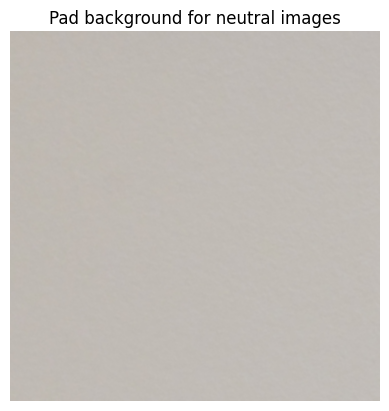

In [9]:
pad_bg = neutral_images[1][0:1000,0:1000,:]
pad_bg = cv.GaussianBlur(pad_bg, (7,7), 0)

plot_image(pad_bg, 'Pad background for neutral images')

In [10]:
neutral_save_path = "data/test_cropped_coins/neutral"

segment_and_save_all_img(imgs_folder_path = image_path_neutral,
                             background_img = median_neutral_bg,
                             transformation_function = neutral_img_transform,
                             thresholds = [negative_rgb_neutral_threshold], 
                             pad_bg = pad_bg,
                             output_folder_path = neutral_save_path)

100%|██████████| 63/63 [00:44<00:00,  1.43it/s]


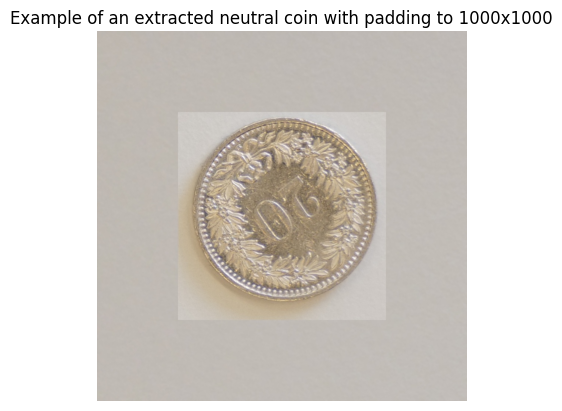

In [11]:
exemple_neutral_coin_path = neutral_save_path + "/L0000001/L0000001_0.JPG"

exemple_neutral_coin = read_image(exemple_neutral_coin_path)
plot_image(exemple_neutral_coin, 'Example of an extracted neutral coin with padding to 1000x1000')

In [12]:
#For memory issues
del neutral_images
del median_neutral_bg
del pad_bg
del exemple_neutral_coin

## Noisy Background Coin Extraction

Specificity here: we noticed there were two types of noisy background, we simply average both.

In [13]:
noisy_images = read_all_images(image_dir_triage + 'noisy')
median_noisy_bg = read_image(f"{average_bg_path}/median_noisy_no_ood_bg.jpg")
median_noisy_bg2 = read_image(f"{average_bg_path}/median_noisy_ood_bg.jpg")
average = np.mean([median_noisy_bg, median_noisy_bg2], axis=0).astype(median_noisy_bg.dtype)

negative_lab_noisy_threshold = ThresholdLAB(
    min_l = 0,
    max_l = 27,
    min_a = -100,
    max_a = 100,
    min_b = -5,
    max_b = 23,
    type='-'
    )

def noisy_img_transform(img):
    processed_img = img.copy()
    
    processed_img = remove_objects(processed_img, size = 500)
    processed_img = apply_closing(processed_img, 7)

    return processed_img.astype(np.uint8)



Reading images in data/test_triage/noisy...: 100%|██████████| 62/62 [00:30<00:00,  2.06it/s]


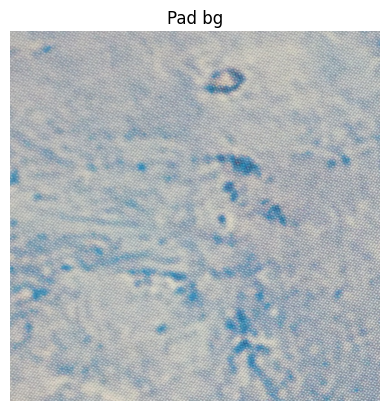

In [14]:
pad_bg = noisy_images[14][500:1500,0:1000,:]

plot_image(pad_bg, title="Pad bg")

In [15]:
noisy_save_path = "data/test_cropped_coins/noisy"

segment_and_save_all_img(imgs_folder_path = image_path_noisy,
                             background_img = average,
                             transformation_function = noisy_img_transform,
                             thresholds = [negative_lab_noisy_threshold], 
                             pad_bg = pad_bg,
                             output_folder_path = noisy_save_path,
                             plot = False)

100%|██████████| 62/62 [01:37<00:00,  1.58s/it]


In [16]:
#For memory issues
del noisy_images
del median_noisy_bg
del median_noisy_bg2
del average

## Hand Background Coin Extraction

For the extraction of coins on hand back ground we use a different technique:
Since the average or median was not helping here, we went with another approach. This method is detailed in `tuning_and_training.ipynb` 
The details of the hyperparameters choice, can be found in `segementation_utils`

Reading images in data/test_triage/hand...: 100%|██████████| 37/37 [00:15<00:00,  2.47it/s]


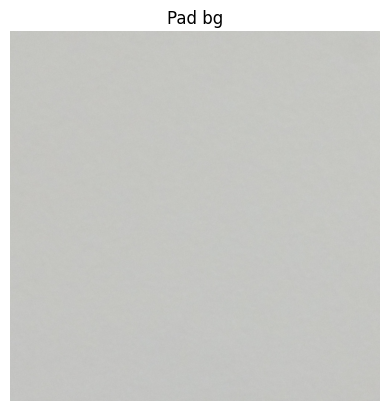

In [17]:
hand_images = read_all_images(image_dir_triage + 'hand')
pad_bg = hand_images[9][0:1000,1000:2000,:]

plot_image(pad_bg, title="Pad bg")

In [18]:
hand_save_path = "data/test_cropped_coins/hand"


segment_and_save_all_img_2(imgs_folder_path = image_path_hand,
                           pad_bg = pad_bg,
                           output_folder_path = hand_save_path,
                            processing_size=USE_SIZE_REF,
                            min_area=3000)

100%|██████████| 37/37 [04:49<00:00,  7.82s/it]


In [19]:
#For memory issues
del hand_images
del pad_bg

Note: For this extraction, some HP were difficult to compute to have the best possible result. We have a few 'no coins' coins picked out. We decided to still go with them and to train a 'not a coin' class in the classification, in order to adjust this problem if it happened on the test set.

# Coin Classification

Once the coins are extracted we can now classify them. To do so:
- We trained a classifer using transfer learning on the `EfficientNet_V2_S_Weights` model from the `torchvision` library.
- We manually annotated each coin we sextracte from our train set using a web app `coin_labeling_app.py`
- We added the class `Not a coin` (in addition to `OOD`) to handle the cases our segmentation is wrong and perfomred augmentation on our train set (rotation and blurring).
- The augmentations were performed to balance the number of samples of each class. No augmentation was done on our validation set (20% of the original train set).
- The preprocessing also includes a cropping and resizing so they can be passed to the model as 224x224 `RGB` images as well as normalization

Again, for more details about the training of this model, please see `tuning_and_training.ipynb` and `coin_classification.py`

In [13]:
# Load the model previously trained and the label map to convert the output to the class name
class_to_idx = json.load(open('models_weights/label_map.json'))
print(class_to_idx)
idx_to_class = {v: k for k, v in class_to_idx.items()}
print("Number of classes: ", len(class_to_idx.keys()))
model = get_model(num_classes=len(class_to_idx))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_state_dict = torch.load('models_weights/efficient_net_coin_classifier.pth', map_location=device)
model.load_state_dict(model_state_dict)

{'2CHF': 0, '2EUR': 1, '0.5CHF': 2, '0.5EUR': 3, '0.2EUR': 4, '0.1EUR': 5, '0.02EUR': 6, 'Not a coin': 7, '1CHF': 8, '5CHF': 9, '0.01EUR': 10, '0.05CHF': 11, '0.1CHF': 12, '0.2CHF': 13, '0.05EUR': 14, 'OOD': 15, '1EUR': 16}
Number of classes:  17


<All keys matched successfully>

In [14]:
# Get the path of the cropped test images
test_coins_path = "data/test_cropped_coins"
bg_types = os.listdir(test_coins_path)

# Output Data to be filled
image_classifications = {p[:-4]:[] for p in test_image_paths}

In [17]:
# Test the data loader
model.eval()
for bg_type in bg_types:
    test_dataloader_path = test_coins_path + '/' + bg_type
    test_dataloader = get_test_data_loader(test_dataloader_path, batch_size=8)

    for batch, image_names in tqdm(test_dataloader, total=len(test_dataloader), desc=f'Testing {bg_type}'):
        batch = batch.to(device)
        outputs = model(batch)
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.cpu().numpy()
        for name, pred in zip(image_names, predicted):
            image_classifications[name].append(idx_to_class[pred])
print(image_classifications)

Testing neutral:   0%|          | 0/45 [00:00<?, ?it/s]

Testing hand: 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]

{'L0000000': ['2EUR', '0.2CHF', '0.2CHF'], 'L0000001': ['0.2CHF', '0.5EUR', '0.2CHF', '2CHF', '1EUR', '0.05CHF', '1EUR', '0.05EUR', '0.5CHF', '2CHF', '0.2CHF', '0.5EUR', '0.2CHF', '2CHF', '1EUR', '0.05CHF', '1EUR', '0.05EUR', '0.5CHF', '2CHF', '0.2CHF', '0.5EUR', '0.2CHF', '2CHF', '1EUR', '0.05CHF', '1EUR', '0.05EUR', '0.5CHF', '2CHF'], 'L0000002': ['5CHF', '2CHF', '5CHF', '0.1CHF', '5CHF', '2CHF', '5CHF', '0.1CHF'], 'L0000003': ['OOD', '0.02EUR', '0.1CHF', '0.5CHF', '0.1EUR', '0.05CHF', '0.5CHF', 'OOD', 'OOD', '0.02EUR', '0.1CHF', '0.5CHF', '0.1EUR', '0.05CHF', '0.5CHF', 'OOD', 'OOD', '0.02EUR', '0.1CHF', '0.5CHF', '0.1EUR', '0.05CHF', '0.5CHF', 'OOD'], 'L0000004': ['2CHF', '1EUR', '0.2CHF', '0.5CHF', '0.1CHF', '0.02EUR', '2CHF', '1EUR', '0.2CHF', '0.5CHF', '0.1CHF', '0.02EUR', '2CHF', '1EUR', '0.2CHF', '0.5CHF', '0.1CHF', '0.02EUR'], 'L0000005': ['5CHF', '2CHF', '0.2CHF', '0.2CHF', '0.02EUR', '0.5CHF', '0.1CHF', '0.2CHF', '5CHF', '2CHF', '0.2CHF', '0.2CHF', '0.02EUR', '0.5CHF', '0.1C

# Kaggle submission creation

Here we simply aggragate back the coins we classifed to get the count of each coin type per image.

In [18]:
# Convert the image classifications to the required format
not_a_coin_name = 'Not a coin'
label_types = list(pd.read_csv('data/train_labels.csv').columns[1:]) + [not_a_coin_name]
image_classifications_idx = {k: [label_types.index(l) for l in v] for k, v in image_classifications.items()}

# Create the submission file
test_labels = {k: [0 for _ in range(len(label_types))] for k in image_classifications.keys()}
for k, v in image_classifications_idx.items():
    for i in v:
        test_labels[k][i] += 1
        
test_labels_df = pd.DataFrame.from_dict(test_labels, orient='index', columns=label_types)
test_labels_df.index.name = 'id'

# Remove not a coin column and save the test label file
test_labels_df = test_labels_df.drop(columns=not_a_coin_name)
test_labels_df.to_csv('data/test_labels.csv')
test_labels_df

,5CHF,2CHF,1CHF,0.5CHF,0.2CHF,0.1CHF,0.05CHF,2EUR,1EUR,0.5EUR,0.2EUR,0.1EUR,0.05EUR,0.02EUR,0.01EUR,OOD
id,,,,,,,,,,,,,,,,
L0000000,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0
L0000001,0,6,0,3,6,0,3,0,6,3,0,0,3,0,0,0
L0000002,4,2,0,0,0,2,0,0,0,0,0,0,0,0,0,0
L0000003,0,0,0,6,0,3,3,0,0,0,0,3,0,3,0,6
L0000004,0,3,0,3,3,3,0,0,3,0,0,0,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
L0000157,0,1,1,0,0,0,0,2,0,0,0,0,0,0,0,0
L0000158,2,0,0,0,0,2,2,0,0,2,0,0,2,2,0,2
L0000159,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
